In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
from mnk import MNK
import itertools
from pprint import pprint

In [3]:
df = pd.read_csv("DataSet3_1.csv", sep=',')
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["OAT (F)"] = df["OAT (F)"].astype(float)
df = df.rename(columns={"OAT (F)": "OAT", "Power (kW)": "Power"})
df = df.drop(df.loc[(df["OAT"] == 0) | (df["Power"] == 0)].index)
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34915 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  34915 non-null  datetime64[ns]
 1   OAT        34915 non-null  float64       
 2   Power      34915 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.1 MB


In [4]:
df

,Timestamp,OAT,Power
0,2010-01-01 01:15:00,51.0,165.1
1,2010-01-01 01:30:00,51.0,151.6
2,2010-01-01 01:45:00,51.0,146.9
3,2010-01-01 02:00:00,51.0,153.7
4,2010-01-01 02:15:00,51.0,153.8
...,...,...,...
34935,2010-12-30 23:00:00,47.0,285.8
34936,2010-12-30 23:15:00,44.0,206.6
34937,2010-12-30 23:30:00,44.0,205.9
34938,2010-12-30 23:45:00,44.0,189.4


In [5]:
df_s = df.sample(34915)
# df_s = df_s.reset_index(drop=True)
df_s = df_s.sort_values(by="Timestamp")
df_s

,Timestamp,OAT,Power
0,2010-01-01 01:15:00,51.0,165.1
1,2010-01-01 01:30:00,51.0,151.6
2,2010-01-01 01:45:00,51.0,146.9
3,2010-01-01 02:00:00,51.0,153.7
4,2010-01-01 02:15:00,51.0,153.8
...,...,...,...
34935,2010-12-30 23:00:00,47.0,285.8
34936,2010-12-30 23:15:00,44.0,206.6
34937,2010-12-30 23:30:00,44.0,205.9
34938,2010-12-30 23:45:00,44.0,189.4


In [6]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())


y = df_s["OAT"].values
x = df_s["Timestamp"].values.astype("float64")
# x = np.array([1, 2, 3, 4])
# y = np.array([1, 1, 3, 8])

In [18]:
# y=c0+c1*x+c2*x^2
funcs = [
    lambda x: x ** 0,
    lambda x: x,
    lambda x: x ** 2,
]
# funcs = [
#     lambda x: x ** 0,
#     lambda x: x * np.log2(x),
#     lambda x: math.e ** x,
# ]

a = np.array([f(x) for f in funcs]).T

In [19]:
a

array([[1.00000000e+00, 1.26230850e+18, 1.59342275e+36],
       [1.00000000e+00, 1.26230940e+18, 1.59342502e+36],
       [1.00000000e+00, 1.26231030e+18, 1.59342729e+36],
       ...,
       [1.00000000e+00, 1.29375180e+18, 1.67379372e+36],
       [1.00000000e+00, 1.29375270e+18, 1.67379605e+36],
       [1.00000000e+00, 1.29375360e+18, 1.67379838e+36]])

In [20]:
c = np.dot(np.dot(np.linalg.inv(np.dot(a.T, a)), a.T), y)

In [21]:
c

array([-9.59127785e+04,  1.49958452e-13, -5.85756788e-32])

In [22]:
def global_func(x):
    result = 0
    for i in range(len(funcs)):
        result += c[i] * funcs[i](x)
        # print(x, c[i] * funcs[i](x))
    return result

In [23]:
global_func(x)

array([45.23123355, 45.23310307, 45.23497249, ..., 52.63566132,
       52.63421557, 52.63276974])

In [24]:
pd.DataFrame({"func": global_func(x), "y": y})

,func,y
0,45.231234,51.0
1,45.233103,51.0
2,45.234972,51.0
3,45.236842,51.0
4,45.238711,51.0
...,...,...
34910,52.638553,47.0
34911,52.637107,44.0
34912,52.635661,44.0
34913,52.634216,44.0


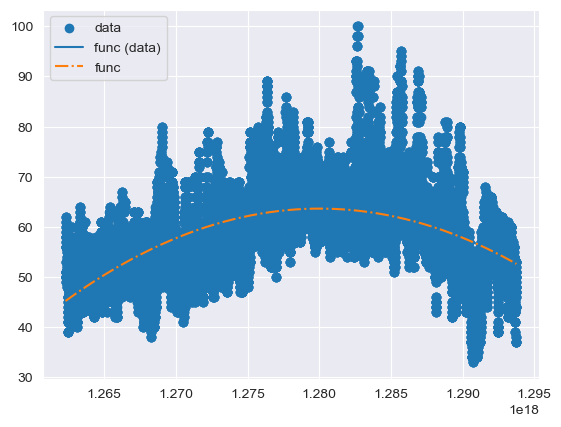

In [25]:
x_new = np.linspace(x.min(), x.max(), num=500, endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
plt.scatter(x, y, label='data')
plt.plot(np.sort(x), global_func(np.sort(x)), label='func (data)')
plt.plot(x_new, global_func(x_new), '-.', label="func")
plt.legend(loc='best')
ax = plt.gca()
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])
plt.show()

In [26]:
couples = list(itertools.combinations(df.columns, 2))
couples

[('Timestamp', 'OAT'), ('Timestamp', 'Power'), ('OAT', 'Power')]

In [27]:
funcs = [
    lambda x: x ** 0,
    lambda x: x,
    lambda x: x ** 2,
]

mnks = [MNK(df[couple[0]].values.astype("float64"), df[couple[1]].values.astype("float64"), funcs) for couple in
        couples]

array([-9.59127785e+04,  1.49958452e-13, -5.85756788e-32])


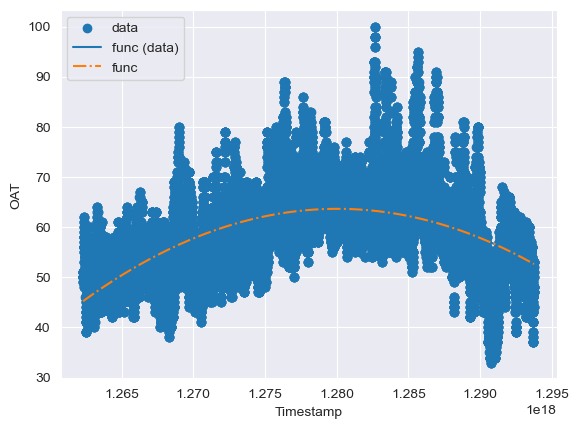

array([-3.16599077e+05,  4.94518706e-13, -1.92935306e-31])


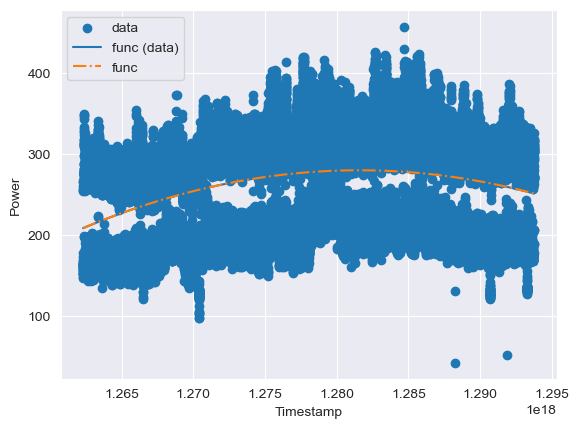

array([-1.93767714e+01,  4.88852838e+00, -1.48119880e-03])


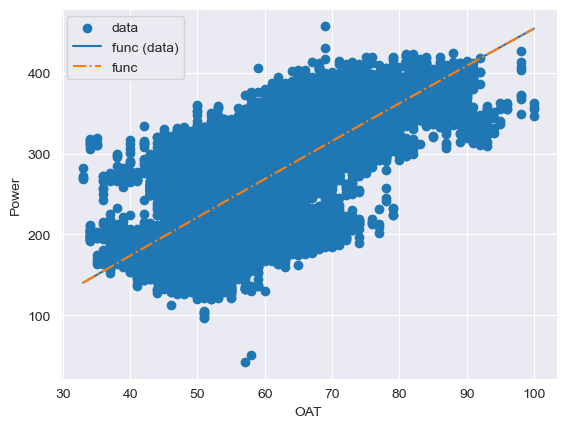

In [28]:
for i, mnk in enumerate(mnks):
    x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
                        endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    plt.scatter(mnk.x, mnk.y, label='data')
    plt.plot(np.sort(mnk.x), mnk.func(np.sort(mnk.x)), label='func (data)')
    plt.plot(x_new, mnk.func(x_new), '-.', label="func")
    plt.legend(loc='best')
    plt.xlabel(couples[i][0])
    plt.ylabel(couples[i][1])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    pprint(mnk.c)
    plt.show()